In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pylab as plt
# import vision.sim_tools.connectors.kernel_connectors as kconn
from vision.spike_tools.vis import my_imshow, plot_spikes, \
                                   plot_output_spikes, \
                                   imgs_in_T_from_spike_array
# from vision.sim_tools.vis import plot_connector_3d
# import vision.sim_tools.kernels.center_surround as csgen
# import vision.sim_tools.kernels.gabor as gabgen

from mpl_toolkits.mplot3d import axes3d, Axes3D

from vision.retina import Retina, dvs_modes, MERGED
from vision.spike_tools.pattern import pattern_generator as pat_gen

from pyNN import nest as sim


def setup_cam_pop(sim, spike_array, img_w, img_h, w2s=1.6):
    pop_size = img_w*img_h*2
    cell = sim.IF_curr_exp
    params = { 'cm': 0.2,  # nF
               'i_offset': 0.0,
               'tau_m': 10.0,
               'tau_refrac': 2.0,
               'tau_syn_E': 1.,
               'tau_syn_I': 1.,
               'v_reset': -70.0,
               'v_rest': -65.0,
               'v_thresh': -55.4
             }
    cam_pop = sim.Population(pop_size, cell, params,
                             label='camera')
    dmy_pops = []
    dmy_prjs = []
    for i in range(pop_size):
        dmy_pops.append(sim.Population(1, sim.SpikeSourceArray, 
                                       {'spike_times': spike_array[i]},
                                       label='pixel (row, col) = (%d, %d)'%\
                                       (i//img_w, i%img_w)))
        conn = [(0, i, w2s, 1)]
        dmy_prjs.append(sim.Projection(dmy_pops[i], cam_pop,
                                       sim.FromListConnector(conn),
                                       target='excitatory'))
    
    return cam_pop, dmy_pops, dmy_prjs



def plot_out_spikes(on_spikes, off_spikes, img_w, img_h, 
                    end_t_ms, ftime_ms, thresh, title):
    on_imgs = imgs_in_T_from_spike_array(on_spikes, img_w, img_h, 
                                         0, end_t_ms, ftime_ms, 
                                         out_array=True, thresh=thresh)

    off_imgs = imgs_in_T_from_spike_array(off_spikes, img_w, img_h, 
                                          0, end_t_ms, ftime_ms, 
                                          out_array=True, thresh=thresh)

    num_imgs = len(on_imgs)
    cols = 5
    rows = num_imgs//cols + 1
    figw = 2
    fig = plt.figure(figsize=(figw*cols, figw*rows))
    for i in range(num_imgs):
        img = np.zeros((img_w, img_h, 3), dtype=np.uint8)
        img[:, :, 1] = off_imgs[i]*4
        img[:, :, 0] = on_imgs[i]*4
        ax = plt.subplot(rows, cols, i+1)
        my_imshow(ax, img, cmap=None)
    # plot_spikes(spikes)
    plt.suptitle(title)
    plt.show()

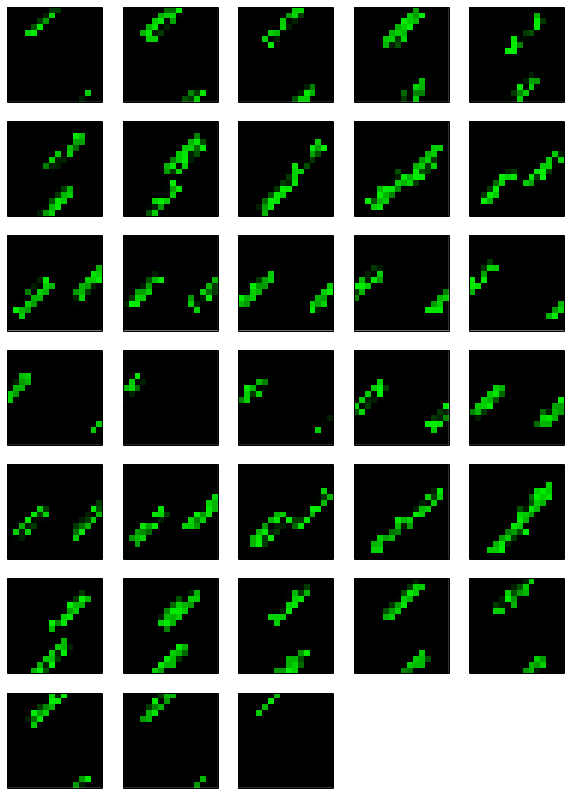

In [3]:
img_w, img_h = 16, 16
num_neurons = img_w*img_h*2
fps = 30
frames = 32
thresh = 25
deg = 135
dx = 1.
'''spikes_pol_MERGED_enc_RATE_
   thresh_25_hist_99_
   inh_False___
   64_frames_at_
   30fps_
   32x32_res_spikes
'''
on_time_ms  = int( frames*(1000./fps) )
ftime_ms    = int( 1000./fps )
off_time_ms = 0
start_time  = 10
spikes_dir = './moving_bar_spikes/deg_%d___dx_%f'%(deg, dx)
spikes = pat_gen.img_spikes_from_to(spikes_dir, num_neurons, 0, 1, 
                                    on_time_ms, off_time_ms,
                                    start_time)



imgsU = imgs_in_T_from_spike_array(spikes[:img_w*img_h], img_w, img_h, 
                                   0, on_time_ms, ftime_ms, 
                                   out_array=False, thresh=25)
imgsD = imgs_in_T_from_spike_array(spikes[img_w*img_h:], img_w, img_h, 
                                   0, on_time_ms, ftime_ms, 
                                   out_array=False, thresh=25)
num_imgs = len(imgsU)
cols = 5
rows = num_imgs//cols + 1
figw = 2
fig = plt.figure(figsize=(figw*cols, figw*rows))
for i in range(num_imgs):
#     out_img = np.zeros((img_w, img_h, 3), dtype=np.uint8)
#     out_img[:, :, 1] = imgsU[i]
#     out_img[:, :, 0] = imgsD[i]
    ax = plt.subplot(rows, cols, i+1)
#     my_imshow(ax, out_img, cmap=None)
    my_imshow(ax, imgsU[i], cmap=None)
# plot_spikes(spikes)

plt.show()

In [4]:
w2s = 1.7
sim.setup(timestep=1., max_delay=12., min_delay=1.)

cam, ssa_cam, prj_cam = setup_cam_pop(sim, spikes, 
                                      img_w, img_h, w2s=w2s)
cam.record()
cfg = {'record': {'voltages': False, 
                  'spikes': True,
                  'weights': False
                 },
       'w2s': w2s,
      }
mode = dvs_modes[MERGED]
retina = Retina(sim, cam, img_w, img_h, mode, cfg=cfg)

run_time = 2500
sim.run(2500)

out_spks = {}
for k in retina.pops.keys():
    out_spks[k] = {}
    for p in retina.pops[k].keys():
        out_spks[k][p] = {}
        if isinstance(retina.pops[k][p], dict):
            for t in retina.pops[k][p].keys():
                
                key = "%s__%s__%s"%(k, p, t)
                try:
                    out_spks[k][p][t] = retina.pops[k][p][t].getSpikes(\
                                                     compatible_output=True)
                except:
                    print("no spikes for population %s"%(key))
#         else:
#             out_spks[k][p] = {}
#             key = "%s__%s"%(k, p)
#             try:
#                 out_spks[k][p][p] = retina.pops[k][p].getSpikes(\
#                                                      compatible_output=True)
#             except:
#                 print("no spikes for population %s"%(key))
            
# out_spks['camera'] = cam.getSpikes(compatible_output=True)
sim.end()

Building Retina (16 x 16)
	Building kernels...
		done!
	Building connectors...
		done!
	Building populations...
		done!
	Building projections...
		done!


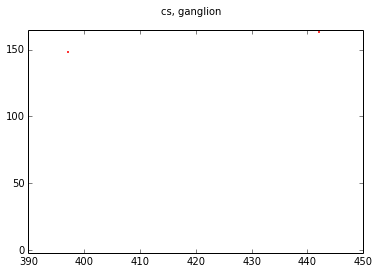

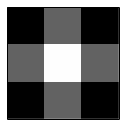

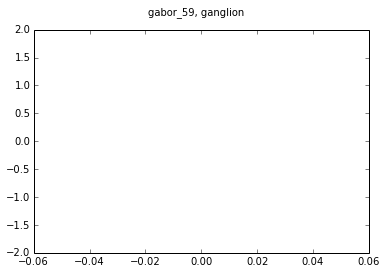

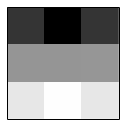

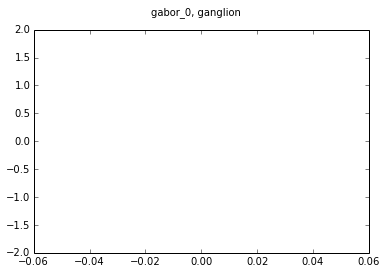

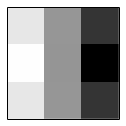

In [6]:



for p in out_spks['on'].keys():
    for t in out_spks['on'][p].keys():
        if t != 'ganglion':
            continue
            
        fig = plt.figure()#figsize=(12, 8))
        plot_output_spikes(out_spks['on'][p][t], color='g')
        plot_output_spikes(out_spks['off'][p][t], color='r')
        plt.suptitle("%s, %s"%(p, t))
#         plt.show()
        if p == 'cs':
            krn = retina.cs
        else:
            krn = retina.gab[p]
            
        fig = plt.figure(figsize=(2,2))
        ax = plt.subplot(1,1,1)
        my_imshow(ax, krn)
        plt.show()
#         plot_out_spikes(out_spks['on'][p][t], 
#                         out_spks['off'][p][t], 
#                         img_w, img_h, 
#                         on_time_ms, ftime_ms, thresh=25, 
#                         title="%s, %s"%(p, t))

In [ ]:
fig = plt.figure(figsize=(10, 12))

i = 0
for p in out_spks['on'].keys():
    for t in out_spks['on'][p].keys():
        if t != 'ganglion':
            continue
        if p == 'cs':
            krn = retina.cs
            continue
        else:
            krn = retina.gab[p]
            
        i += 1
        ax = plt.subplot(5,2,i)
        plot_output_spikes(out_spks['on'][p][t], color='g')
        plot_output_spikes(out_spks['off'][p][t], color='r')
        
        i += 1
        ax = plt.subplot(5,2,i)
        my_imshow(ax, krn)

i += 1

ax = plt.subplot(5,2,i)
plot_spikes(spikes[:img_w*img_h], color='g')
plot_spikes(spikes[img_w*img_h:2*img_w*img_h], color='r')
plt.savefig('retina_orient_pres01.png', dpi=150)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 4))

i = 0
for p in out_spks['on'].keys():
    for t in out_spks['on'][p].keys():
        if t != 'ganglion':
            continue
        if p == 'cs':
            krn = retina.cs
            
        else:
            krn = retina.gab[p]
            continue
            
        i += 1
        ax = plt.subplot(2,2,i)
        plot_output_spikes(out_spks['on'][p][t], color='g')
        plot_output_spikes(out_spks['off'][p][t], color='r')
        
        i += 1
        ax = plt.subplot(2,2,i)
        my_imshow(ax, krn)

i += 1

ax = plt.subplot(2,2,i)
plot_spikes(spikes[:img_w*img_h], color='g')
plot_spikes(spikes[img_w*img_h:2*img_w*img_h], color='r')
plt.savefig('retina_ctr-srr_pres01.png', dpi=150)
plt.show()